# Task 1: Basics

In [1]:
#Torch imports 
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader

# Other imports
import requests
import json
import os

import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Let's load the pretrained model and our test dataset.

In [3]:
# loading pretrained ResNet-34 model
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1').to(device)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 211MB/s]


In [4]:
# loading and preprocessing test dataset
mean_norms = np.array([0.485, 0.456, 0.406])
std_norms = np.array([0.229, 0.224, 0.225])
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])


Next we'll load the class names.

In [5]:
# dataset_path = "/kaggle/input/dl-project-3-test-data/TestDataSet"
# dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=plain_transforms)

# # loading the indices look-up table
# json_path = "/kaggle/input/dl-project-3-test-data/TestDataSet/labels_list.json"
# with open(json_path, 'r') as f:
#     idx_table = json.load(f)

In [6]:
dataset_path = "/kaggle/input/d/rigvedshirvalkar/dl-project-3-test-data/TestDataSet"
dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=plain_transforms)
# loading the indices look-up table
import os
json_path = os.path.join(dataset_path, "labels_list.json")
with open(json_path, 'r') as f:
    idx_table = json.load(f)

In [7]:
# To get IMAGENET1K_V1 class names, I don't know
# why this has to be so complicated
url = "https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt"
response = requests.get(url)
class_idx_to_labels = eval(response.text)

In [8]:
# We'll only take the first name, as the other names are the scientific names
class_idx_to_labels = {key: value.split(',')[0] for key, value in class_idx_to_labels.items()}

In [9]:
class_names = {i: str_idx[5:] for i, str_idx in enumerate(idx_table)}

In [20]:
# building mapping from imagenet classes to our test dataset classes
idx_converter = {int(str_idx[:3]): i for i, str_idx in enumerate(idx_table)}
idx_converter

{401: 0,
 402: 1,
 403: 2,
 404: 3,
 405: 4,
 406: 5,
 407: 6,
 408: 7,
 409: 8,
 410: 9,
 411: 10,
 412: 11,
 413: 12,
 414: 13,
 415: 14,
 416: 15,
 417: 16,
 418: 17,
 419: 18,
 420: 19,
 421: 20,
 422: 21,
 423: 22,
 424: 23,
 425: 24,
 426: 25,
 427: 26,
 428: 27,
 429: 28,
 430: 29,
 431: 30,
 432: 31,
 433: 32,
 434: 33,
 435: 34,
 436: 35,
 437: 36,
 438: 37,
 439: 38,
 440: 39,
 441: 40,
 442: 41,
 443: 42,
 444: 43,
 445: 44,
 446: 45,
 447: 46,
 448: 47,
 449: 48,
 450: 49,
 451: 50,
 452: 51,
 453: 52,
 454: 53,
 455: 54,
 456: 55,
 457: 56,
 458: 57,
 459: 58,
 460: 59,
 461: 60,
 462: 61,
 463: 62,
 464: 63,
 465: 64,
 466: 65,
 467: 66,
 468: 67,
 469: 68,
 470: 69,
 471: 70,
 472: 71,
 473: 72,
 474: 73,
 475: 74,
 476: 75,
 477: 76,
 478: 77,
 479: 78,
 480: 79,
 481: 80,
 482: 81,
 483: 82,
 484: 83,
 485: 84,
 486: 85,
 487: 86,
 488: 87,
 489: 88,
 490: 89,
 491: 90,
 492: 91,
 493: 92,
 494: 93,
 495: 94,
 496: 95,
 497: 96,
 498: 97,
 499: 98,
 500: 99}

In [21]:
# building mapping from our test dataset classes to imagenet classes
idx_inv_converter = {i: int(str_idx[:3]) for i, str_idx in enumerate(idx_table)}

Let's compute next the overall accuracy for the base pretrained model.

In [22]:
# using a data loader to loop through entire dataset later
batch_size = 32
loader = DataLoader(dataset, batch_size = batch_size, shuffle = False, drop_last = False)

In [23]:
cor_preds = 0
cor_preds_top5 = 0
total_samples = 0
pretrained_model.eval()
# eval loop
for inputs, labels in loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.no_grad():
        outputs = pretrained_model(inputs) # getting predictions

    top5_indices = outputs.topk(5).indices # getting top5 predictions
    # with a for loop, we'll accumulate across batch quantities for metrics computation
    for l, idx, top5_idx in zip(labels, outputs.argmax(-1), top5_indices):
        idx = idx.item()
        l = l.item()
        converted_l = idx_inv_converter[l] # need to convert classes from our test dataset to imagenet classes
        if idx == converted_l: # top1 correct prediction
            cor_preds += 1
        if converted_l in top5_idx: # top5 correct prediction
            cor_preds_top5 += 1
    total_samples += inputs.shape[0]

In [24]:
final_top1_acc = 100 * cor_preds / total_samples
final_top5_acc = 100 * cor_preds_top5 / total_samples
print(f"Top-1 Accuracy: {final_top1_acc:.2f}%")
print(f"Top-5 Accuracy: {final_top5_acc:.2f}%")

Top-1 Accuracy: 76.00%
Top-5 Accuracy: 94.20%


# Task 2: Pixel-wise attacks

In [25]:
epsilon = 0.02

In [26]:
for p in pretrained_model.parameters():
    p.requires_grad = False # to avoid useless computations

Let's attack the pretrained model using FGSM. It is an attack where we just want the model to be wrong, and not to be wrong and predict a specific class instead of the true class.

In [27]:
cor_preds = 0
cor_preds_top5 = 0
total_samples = 0
pretrained_model.eval()

# denormalization function for visualization purposes
def denormalize(x):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(x.device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(x.device)
    return x.clone() * std + mean

misclassified_examples = []

# Directory to save adversarial dataset
adversarial_dir = "./Adversarial_Test_Set_1"
os.makedirs(adversarial_dir, exist_ok=True)

for inputs, labels in loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    inputs.requires_grad = True # this is the variables we are differentiating with respect to
    outputs = pretrained_model(inputs)
    # we need to convert the labels from our test dataset to imagenet dataset
    imagenet_labels = torch.tensor([idx_inv_converter[l.item()] for l in labels], device = device)

    loss = F.cross_entropy(outputs, imagenet_labels) # compute the loss that we'll maximize next wrt. the images
    loss.backward() # compute the gradients
    grad = inputs.grad.data
    perturbed_inputs = inputs + epsilon * grad.sign() # attack!

    with torch.no_grad():
        preds_after_attack = pretrained_model(perturbed_inputs)

    top5_indices = preds_after_attack.topk(5).indices # getting top5 predictions

    # check whether L∞ distance < epsilon
    l_inf_dist = torch.max(torch.abs(perturbed_inputs - inputs)).item()
    assert l_inf_dist <= epsilon + 1e-6, f"L∞ distance {l_inf_dist} exceeds epsilon {epsilon}"

    # Save perturbed images
    for i, (pert_img, label) in enumerate(zip(perturbed_inputs, labels)):
        class_name = dataset.classes[label.item()]
        class_dir = os.path.join(adversarial_dir, class_name)
        os.makedirs(class_dir, exist_ok=True)
        save_path = os.path.join(class_dir, f"adv_{total_samples + i}.png")
        save_image(denormalize(pert_img), save_path)

    # with a for loop, we'll accumulate across batch quantities for metrics computation
    # and select 5 images that were previously correctly classified but are now 
    # uncorrectly classified
    for i in range(len(labels)):
        idx = preds_after_attack.argmax(-1)[i].item()
        l = labels[i].item()
        prev_idx = outputs.argmax(-1)[i].item()
        top5_idx = top5_indices[i]

        converted_l = idx_inv_converter[l] # need to convert classes from our test dataset to imagenet classes
        # We add 5 misclassified images to a list
        if prev_idx == converted_l and idx != converted_l: # previously right, now wrong
            if len(misclassified_examples) < 5:
                adv_confidences = torch.softmax(preds_after_attack[i], dim = 0).cpu().numpy()
                misclassified_examples.append({
                    'original': inputs[i].detach().clone(),
                    'adversarial': perturbed_inputs[i].detach().clone(),
                    'true_label': converted_l,
                    'adv_confidences': adv_confidences
                })

        if idx == converted_l: # top1 correct prediction
            cor_preds += 1
        if converted_l in top5_idx: # top5 correct prediction
            cor_preds_top5 += 1
    total_samples += inputs.shape[0]

In [28]:
final_top1_acc = 100 * cor_preds / total_samples
final_top5_acc = 100 * cor_preds_top5 / total_samples
print(f"Top-1 Accuracy: {final_top1_acc:.2f}%")
print(f"Top-5 Accuracy: {final_top5_acc:.2f}%")

Top-1 Accuracy: 6.00%
Top-5 Accuracy: 35.40%


Next we'll visualize 5 test cases where the original model no longer classifies as expected.

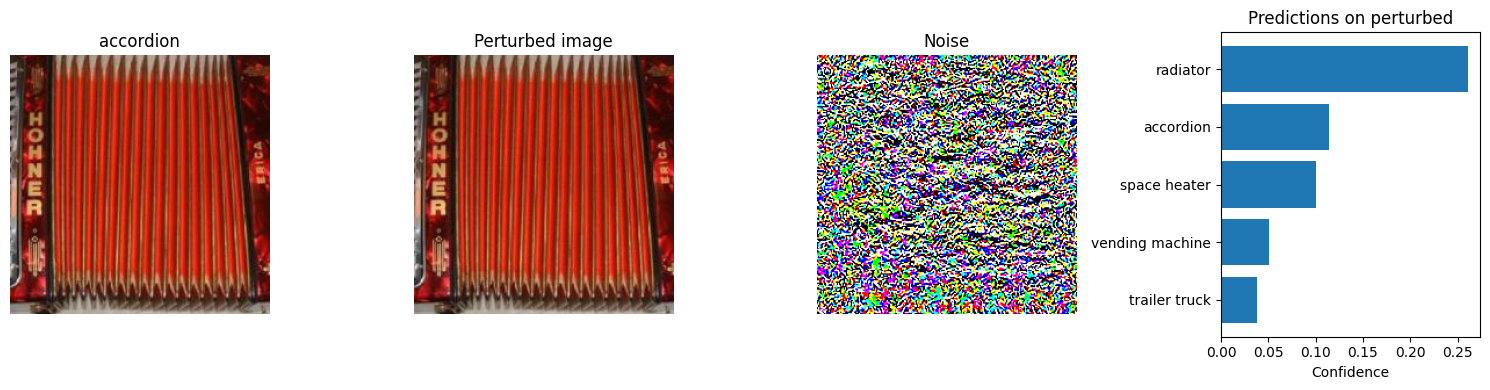

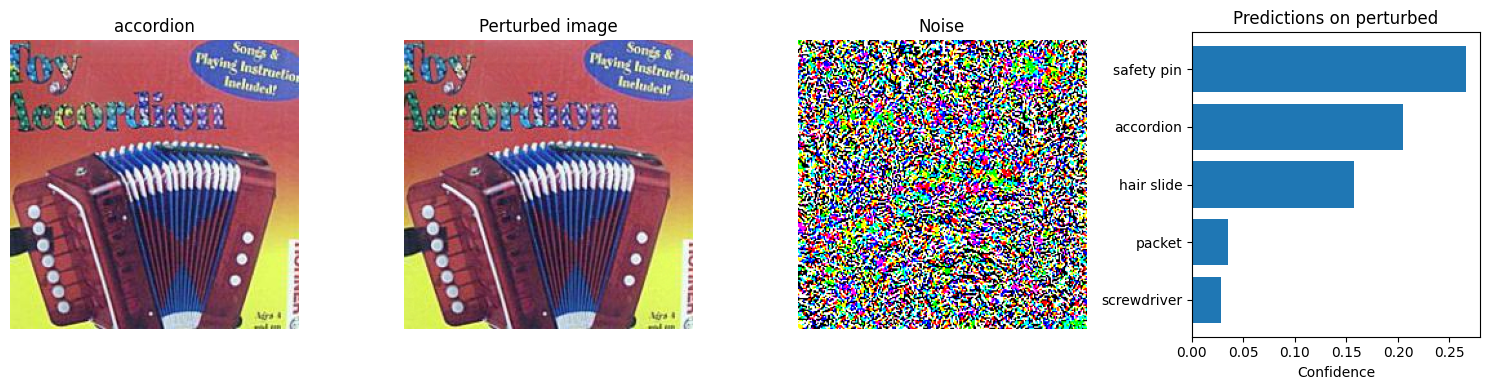

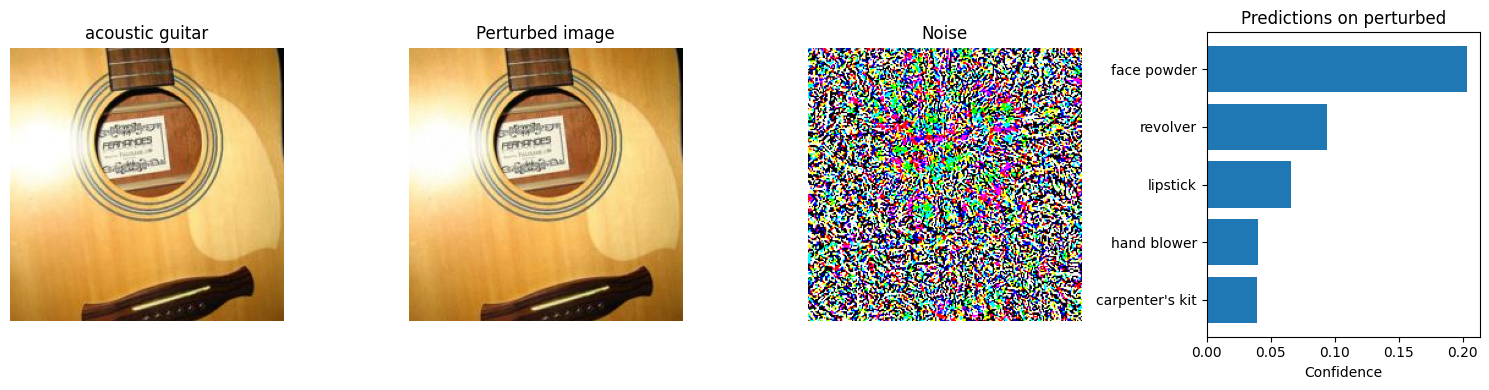

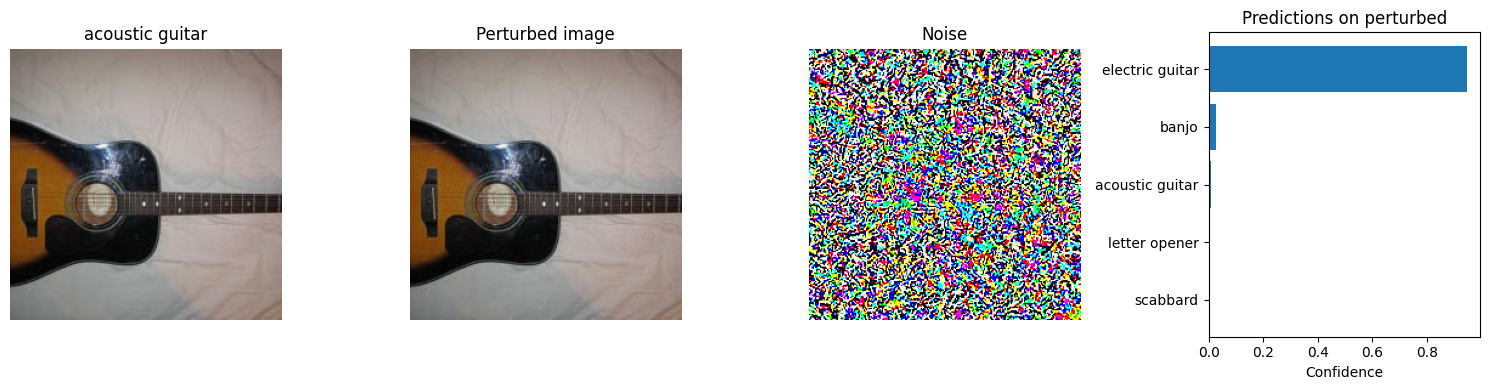

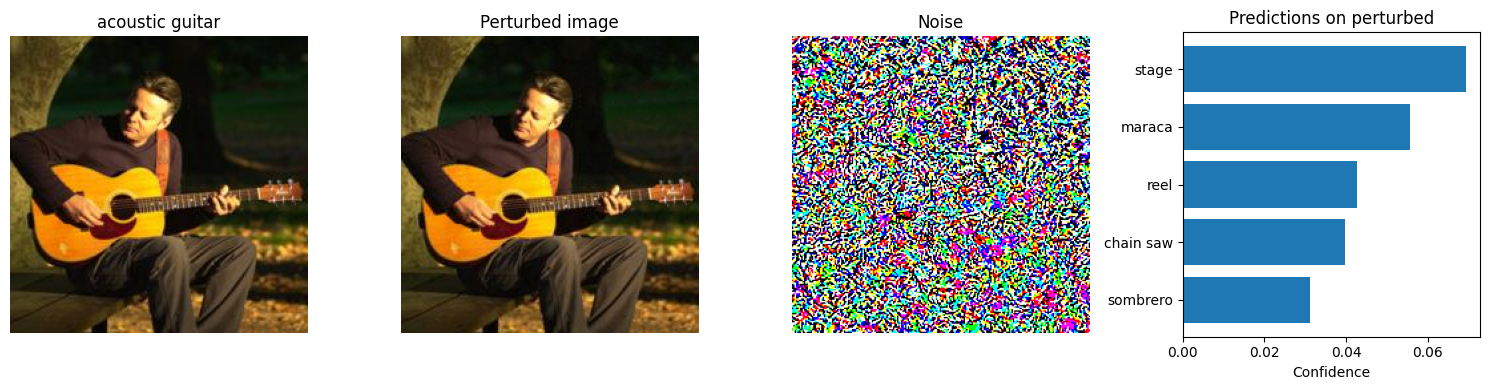

In [29]:
for i in range(5):
    example = misclassified_examples[i]

    orig_img = denormalize(example['original']).cpu()
    adv_img = denormalize(example['adversarial']).cpu()

    # you can get the noise by taking the difference between initial and
    # perturbed image
    noise = (example['adversarial'] - example['original']).cpu()
    # min-max scale the noise to be between 0 and 1, for display purposes
    noise_display = noise - noise.min()
    noise_display = noise_display / (noise_display.max() + 1e-8)

    # get the top5 predictions of the model
    # on the perturbed image
    adv_confidences = example['adv_confidences']
    top5_indices = np.argsort(adv_confidences)[-5:]
    top5_values = adv_confidences[top5_indices]
    top5_names = [class_idx_to_labels[idx] for idx in top5_indices]

    fig, axs = plt.subplots(1, 4, figsize=(15, 4))

    # plot true image
    axs[0].imshow(orig_img.permute(1, 2, 0))
    axs[0].set_title(f"{class_idx_to_labels[example['true_label']]}")
    axs[0].axis('off')

    # plot perturbed image
    axs[1].imshow(adv_img.permute(1, 2, 0))
    axs[1].set_title("Perturbed image")
    axs[1].axis('off')

    # plot noise
    axs[2].imshow(noise_display.permute(1, 2, 0))
    axs[2].set_title("Noise")
    axs[2].axis('off')

    # plot prediction on perturbed
    axs[3].barh(top5_names, top5_values)
    axs[3].set_title("Predictions on perturbed")
    axs[3].set_xlabel("Confidence")

    plt.tight_layout()
    plt.show()

# Task 3: Improved attacks

In [30]:
cor_preds = 0
cor_preds_top5 = 0
total_samples = 0
pretrained_model.eval()

misclassified_examples = []
epsilon = 0.02
alpha = 2. / 255. # step size for PGD
num_steps = 10 # number of PGD iterations
restarts = 1 # number of attacks per image

# Directory to save adversarial dataset
adversarial_dir = "./Adversarial_Test_Set_2"
os.makedirs(adversarial_dir, exist_ok=True)

for inputs, labels in loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    final_top5 = torch.zeros((restarts, inputs.shape[0]), device = device)
    final_deltas = torch.zeros((restarts,) + inputs.shape, device = device)

    with torch.no_grad():
        preds_before_attack = pretrained_model(inputs)  # original predictions

    # we need to convert the labels from our test dataset to imagenet dataset
    imagenet_labels = torch.tensor([idx_inv_converter[l.item()] for l in labels], device=device)

    # We are going to take the two most predicted classes by the model
    # should be uncommented for targeted attacks
    top2_indices = preds_before_attack.topk(2).indices  # getting top2 predictions
    attack_targets = torch.zeros_like(labels)
    for i in range(len(labels)):
       l = labels[i].item()
       top2_idx = top2_indices[i]
       converted_l = idx_inv_converter[l] # need to convert classes from our test dataset to imagenet classes
       if top2_idx[0] != converted_l:
           attack_targets[i] = top2_idx[0]
       else:
           attack_targets[i] = top2_idx[1]

    for a in range(restarts):
        delta = torch.zeros_like(inputs, device = device)
        delta.uniform_(-epsilon, epsilon)
        #delta = torch.clamp(delta, 0 - inputs, 1 - inputs) # so that inputs + delta is still in [0, 1] (inputs is in [0, 1])
        delta.requires_grad = True

        # PGD attack: multiple gradient steps
        for _ in range(num_steps):
            outputs = pretrained_model(inputs + delta)

            loss = -F.cross_entropy(outputs, attack_targets) # compute the loss that we'll maximize next wrt. the images (for targeted attacks)
            loss_untarget = F.cross_entropy(outputs, imagenet_labels) # compute the loss that we'll maximize next wrt. the images
            (loss).backward() # compute the gradients
            grad = delta.grad.data

            delta = torch.clamp(delta.detach() + alpha * torch.sign(grad), min=-epsilon, max=epsilon) # projected gradient step
            #delta = torch.clamp(delta, 0 - inputs, 1 - inputs) # so that inputs + delta is still in [0, 1] (inputs is in [0, 1])
            delta.requires_grad = True

        with torch.no_grad():
            preds_after_attack = pretrained_model(inputs + delta)  # adversarial predictions

        top5_indices = preds_after_attack.topk(5).indices  # getting top5 predictions
        for i in range(len(labels)):
            top5_idx = top5_indices[i]
            l = labels[i].item()
            converted_l = idx_inv_converter[l]
            if converted_l in top5_idx:
                final_top5[a, i] = 1

        final_deltas[a] = delta.detach().clone()

    best_attack_idx = final_top5.argmin(0)
    # Final forward pass on perturbed inputs
    perturbed_inputs = inputs + torch.take_along_dim(final_deltas, indices = best_attack_idx.reshape(1, -1, 1, 1, 1), dim = 0).squeeze(0).detach()
    with torch.no_grad():
        preds_after_attack = pretrained_model(perturbed_inputs)  # adversarial predictions

    top5_indices = preds_after_attack.topk(5).indices  # getting top5 predictions

    # check whether L∞ distance < epsilon
    l_inf_dist = torch.max(torch.abs(perturbed_inputs - inputs)).item()
    assert l_inf_dist <= epsilon + 1e-6, f"L∞ distance {l_inf_dist} exceeds epsilon {epsilon}"

    # Save perturbed images
    for i, (pert_img, label) in enumerate(zip(perturbed_inputs, labels)):
        class_name = dataset.classes[label.item()]
        class_dir = os.path.join(adversarial_dir, class_name)
        os.makedirs(class_dir, exist_ok=True)
        save_path = os.path.join(class_dir, f"adv_{total_samples + i}.png")
        save_image(denormalize(pert_img), save_path)

    # with a for loop, we'll accumulate across batch quantities for metrics computation
    # and select 5 images that were previously correctly classified but are now 
    # uncorrectly classified
    for i in range(len(labels)):
        idx = preds_after_attack.argmax(-1)[i].item()
        l = labels[i].item()
        prev_idx = preds_before_attack.argmax(-1)[i].item()
        top5_idx = top5_indices[i]

        converted_l = idx_inv_converter[l] # need to convert classes from our test dataset to imagenet classes
        # We add 5 misclassified images to a list
        if prev_idx == converted_l and idx != converted_l: # previously right, now wrong
            if len(misclassified_examples) < 5:
                adv_confidences = torch.softmax(preds_after_attack[i], dim = 0).cpu().numpy()
                misclassified_examples.append({
                    'original': inputs[i].detach().clone(),
                    'adversarial': perturbed_inputs[i].detach().clone(),
                    'true_label': converted_l,
                    'adv_confidences': adv_confidences
                })

        if idx == converted_l: # top1 correct prediction
            cor_preds += 1
        if converted_l in top5_idx: # top5 correct prediction
            cor_preds_top5 += 1

    total_samples += inputs.shape[0]


In [31]:
final_top1_acc = 100 * cor_preds / total_samples
final_top5_acc = 100 * cor_preds_top5 / total_samples
print(f"Top-1 Accuracy: {final_top1_acc:.2f}%")
print(f"Top-5 Accuracy: {final_top5_acc:.2f}%")

Top-1 Accuracy: 0.00%
Top-5 Accuracy: 72.60%


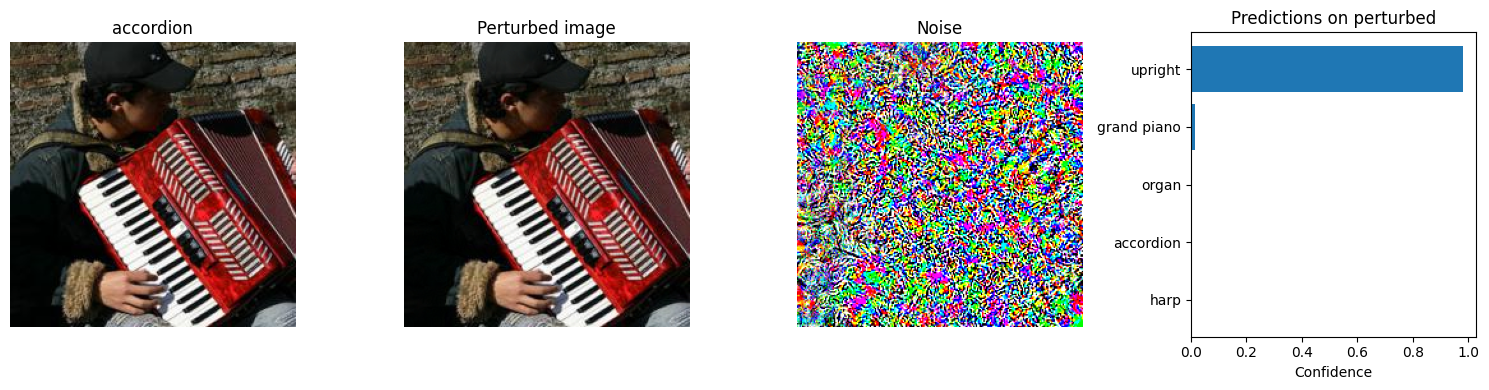

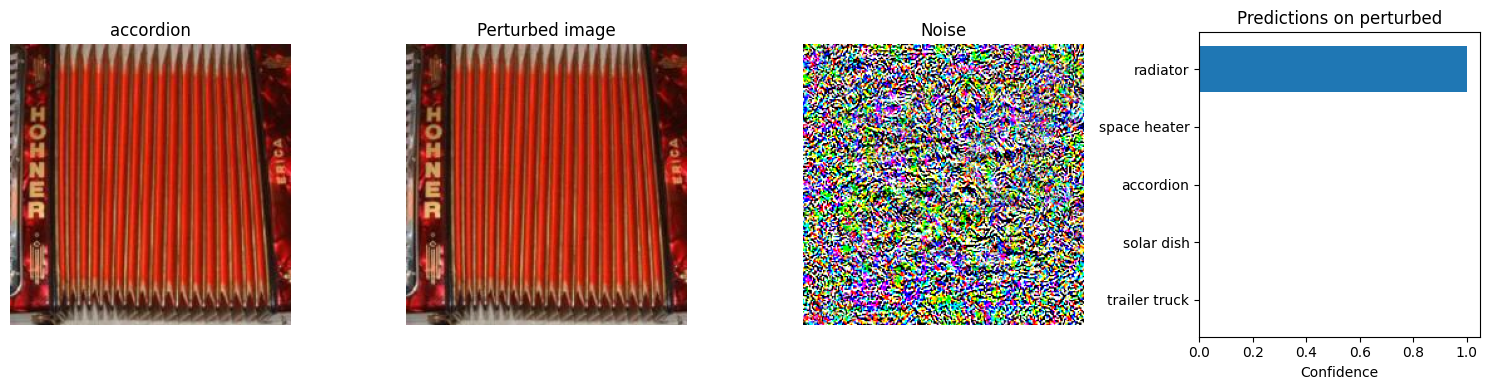

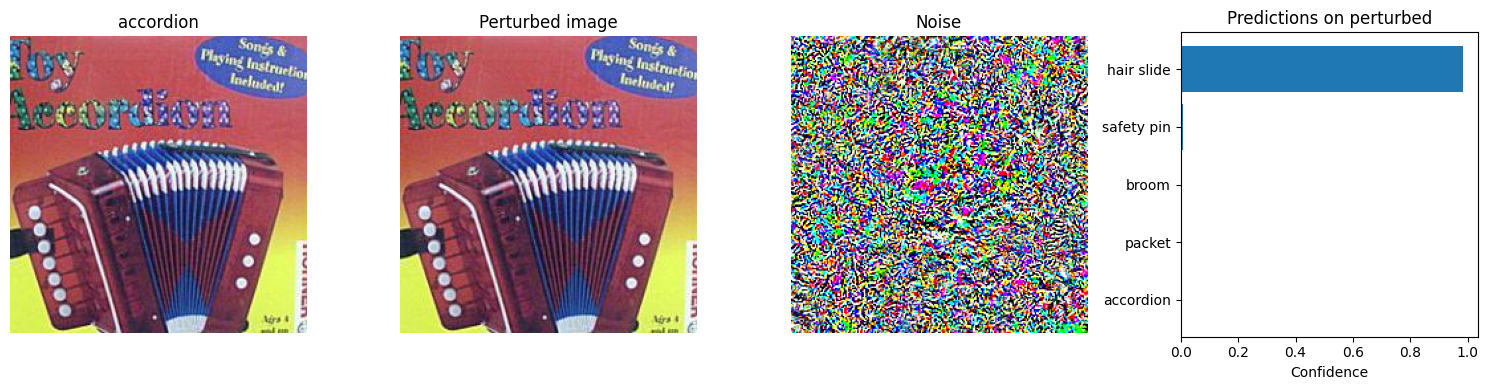

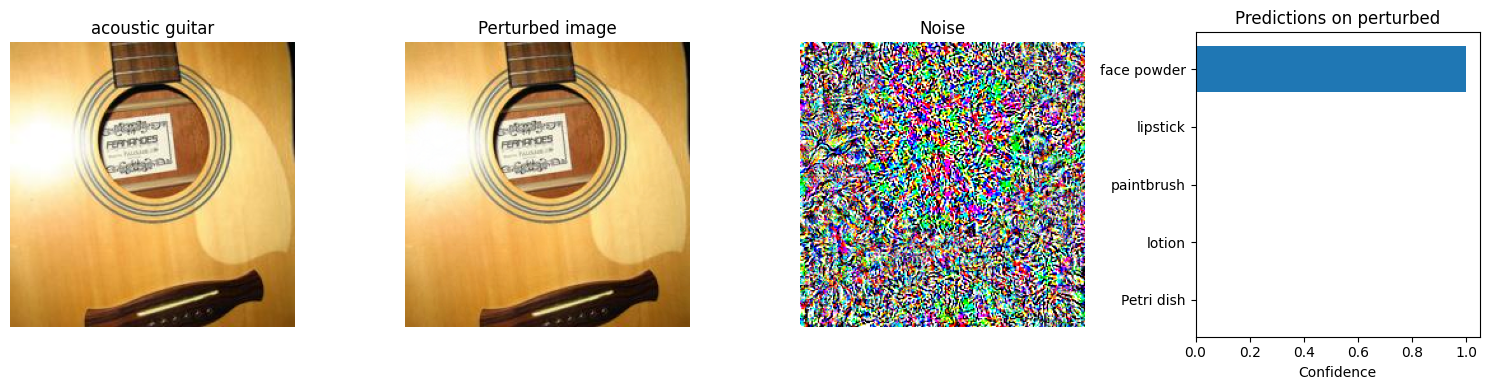

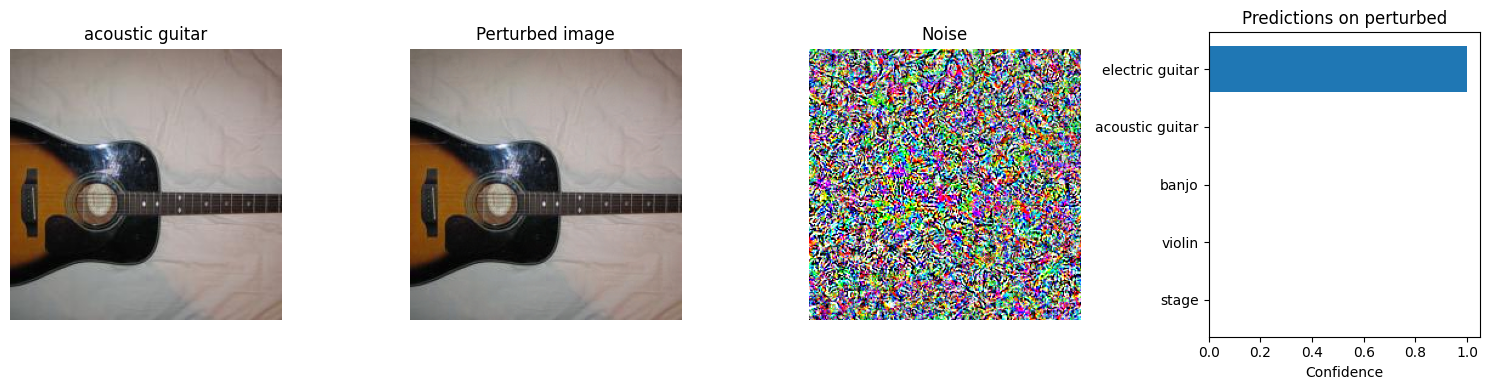

In [32]:
for i in range(5):
    example = misclassified_examples[i]

    orig_img = denormalize(example['original']).cpu()
    adv_img = denormalize(example['adversarial']).cpu()

    # you can get the noise by taking the difference between initial and
    # perturbed image
    noise = (example['adversarial'] - example['original']).cpu()
    # min-max scale the noise to be between 0 and 1, for display purposes
    noise_display = noise - noise.min()
    noise_display = noise_display / (noise_display.max() + 1e-8)

    # get the top5 predictions of the model
    # on the perturbed image
    adv_confidences = example['adv_confidences']
    top5_indices = np.argsort(adv_confidences)[-5:]
    top5_values = adv_confidences[top5_indices]
    top5_names = [class_idx_to_labels[idx] for idx in top5_indices]

    fig, axs = plt.subplots(1, 4, figsize=(15, 4))

    # plot true image
    axs[0].imshow(orig_img.permute(1, 2, 0))
    axs[0].set_title(f"{class_idx_to_labels[example['true_label']]}")
    axs[0].axis('off')

    # plot perturbed image
    axs[1].imshow(adv_img.permute(1, 2, 0))
    axs[1].set_title("Perturbed image")
    axs[1].axis('off')

    # plot noise
    axs[2].imshow(noise_display.permute(1, 2, 0))
    axs[2].set_title("Noise")
    axs[2].axis('off')

    # plot prediction on perturbed
    axs[3].barh(top5_names, top5_values)
    axs[3].set_title("Predictions on perturbed")
    axs[3].set_xlabel("Confidence")

    plt.tight_layout()
    plt.show()

# Task 4: Patch attacks

In [33]:
batch_size = 1
loader = DataLoader(dataset, batch_size = batch_size, shuffle = False, drop_last = False)

In [34]:
cor_preds = 0
cor_preds_top5 = 0
total_samples = 0
pretrained_model.eval()

misclassified_examples = []
epsilon = 0.5
alpha = 50. / 255. # step size for PGD
num_steps = 10 # number of PGD iterations
restarts = 2 # number of attacks per image
patch_size = 32

# Directory to save adversarial dataset
adversarial_dir = "./Adversarial_Test_Set_3"
os.makedirs(adversarial_dir, exist_ok=True)

for inputs, labels in loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    assert inputs.shape[0] == 1, "Batch size for patch attack should only be 1."

    h, w = inputs.shape[-2:]
    x_start = torch.randint(0, h - patch_size, (1,)).item()
    y_start = torch.randint(0, w - patch_size, (1,)).item()

    final_top5 = torch.zeros((restarts, inputs.shape[0]), device = device)
    final_deltas = torch.zeros((restarts, 1, 3, patch_size, patch_size), device = device)

    with torch.no_grad():
        preds_before_attack = pretrained_model(inputs) # original predictions

    # we need to convert the labels from our test dataset to imagenet dataset
    imagenet_labels = torch.tensor([idx_inv_converter[l.item()] for l in labels], device=device)

    # We are going to take the two most predicted classes by the model
    # should be uncommented for targeted attack
    top2_indices = preds_before_attack.topk(2).indices # getting top2 predictions
    attack_targets = torch.zeros_like(labels)
    for i in range(len(labels)):
       l = labels[i].item()
       top2_idx = top2_indices[i]
       converted_l = idx_inv_converter[l] # need to convert classes from our test dataset to imagenet classes
       if top2_idx[0] != converted_l:
           attack_targets[i] = top2_idx[0]
       else:
           attack_targets[i] = top2_idx[1]

    for a in range(restarts):
        delta = torch.zeros((3, patch_size, patch_size), device = device)
        delta.uniform_(-epsilon, epsilon)
        delta.requires_grad = True
    
        # PGD attack: multiple gradient steps
        for _ in range(num_steps):
            attack_inputs = inputs.clone()
            attack_inputs[..., x_start:x_start+patch_size, y_start:y_start+patch_size] += delta
            outputs = pretrained_model(attack_inputs)

            loss = -F.cross_entropy(outputs, attack_targets) # compute the loss that we'll maximize next wrt. the images (for targeted attacks)
            loss_untarget = F.cross_entropy(outputs, imagenet_labels) # compute the loss that we'll maximize next wrt. the images
            (loss).backward() # compute the gradients
            grad = delta.grad.data

            delta = torch.clamp(delta.detach() + alpha * torch.sign(grad), min=-epsilon, max=epsilon) # projected gradient step
            delta.requires_grad = True

        with torch.no_grad():
            preds_after_attack = pretrained_model(attack_inputs) # adversarial predictions
    
        top5_indices = preds_after_attack.topk(5).indices # getting top5 predictions
        for i in range(len(labels)):
            top5_idx = top5_indices[i]
            l = labels[i].item()
            converted_l = idx_inv_converter[l]
            if converted_l in top5_idx:
                final_top5[a, i] = 1

        final_deltas[a] = delta.detach().clone()

    best_attack_idx = final_top5.argmin(0)
    # Final forward pass on perturbed inputs
    best_deltas = torch.take_along_dim(final_deltas, indices = best_attack_idx.reshape(1, -1, 1, 1, 1), dim = 0).squeeze(0).detach()
    perturbed_inputs = inputs.clone()
    perturbed_inputs[..., x_start:x_start+patch_size, y_start:y_start+patch_size] += best_deltas
    with torch.no_grad():
        preds_after_attack = pretrained_model(perturbed_inputs) # adversarial predictions

    top5_indices = preds_after_attack.topk(5).indices # getting top5 predictions

    # check whether L∞ distance < epsilon
    l_inf_dist = torch.max(torch.abs(perturbed_inputs - inputs)).item()
    assert l_inf_dist <= epsilon + 1e-6, f"L∞ distance {l_inf_dist} exceeds epsilon {epsilon}"

    # Save perturbed images
    for i, (pert_img, label) in enumerate(zip(perturbed_inputs, labels)):
        class_name = dataset.classes[label.item()]
        class_dir = os.path.join(adversarial_dir, class_name)
        os.makedirs(class_dir, exist_ok=True)
        save_path = os.path.join(class_dir, f"adv_{total_samples + i}.png")
        save_image(denormalize(pert_img), save_path)

    # with a for loop, we'll accumulate across batch quantities for metrics computation
    # and select 5 images that were previously correctly classified but are now 
    # uncorrectly classified
    for i in range(len(labels)):
        idx = preds_after_attack.argmax(-1)[i].item()
        l = labels[i].item()
        prev_idx = preds_before_attack.argmax(-1)[i].item()
        top5_idx = top5_indices[i]

        converted_l = idx_inv_converter[l] # need to convert classes from our test dataset to imagenet classes
        # We add 5 misclassified images to a list
        if prev_idx == converted_l and idx != converted_l: # previously right, now wrong
            if len(misclassified_examples) < 5:
                adv_confidences = torch.softmax(preds_after_attack[i], dim = 0).cpu().numpy()
                misclassified_examples.append({
                    'original': inputs[i].detach().clone(),
                    'adversarial': perturbed_inputs[i].detach().clone(),
                    'true_label': converted_l,
                    'adv_confidences': adv_confidences
                })

        if idx == converted_l: # top1 correct prediction
            cor_preds += 1
        if converted_l in top5_idx: # top5 correct prediction
            cor_preds_top5 += 1

    total_samples += inputs.shape[0]

In [35]:
final_top1_acc = 100 * cor_preds / total_samples
final_top5_acc = 100 * cor_preds_top5 / total_samples
print(f"Top-1 Accuracy: {final_top1_acc:.2f}%")
print(f"Top-5 Accuracy: {final_top5_acc:.2f}%")

Top-1 Accuracy: 45.00%
Top-5 Accuracy: 91.80%


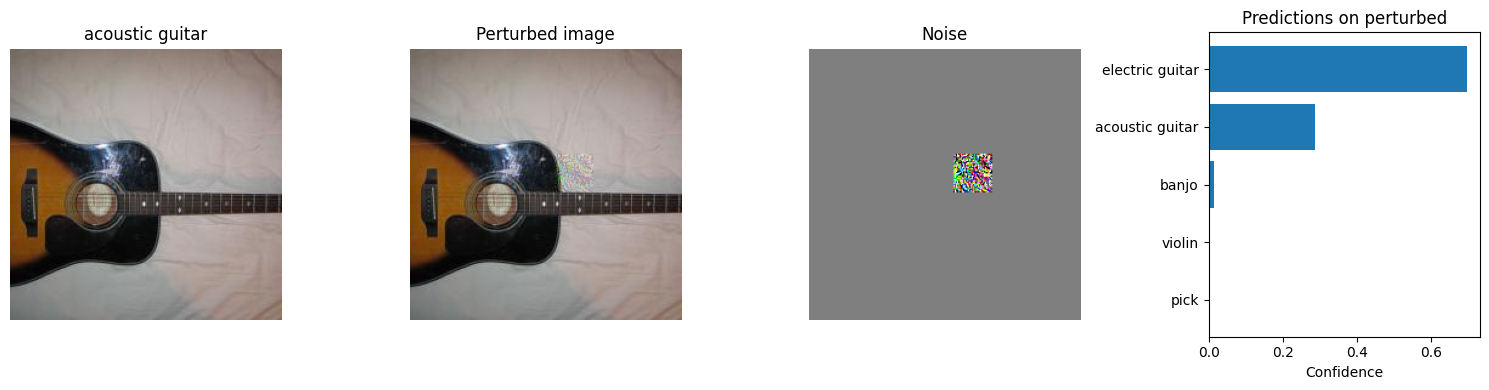

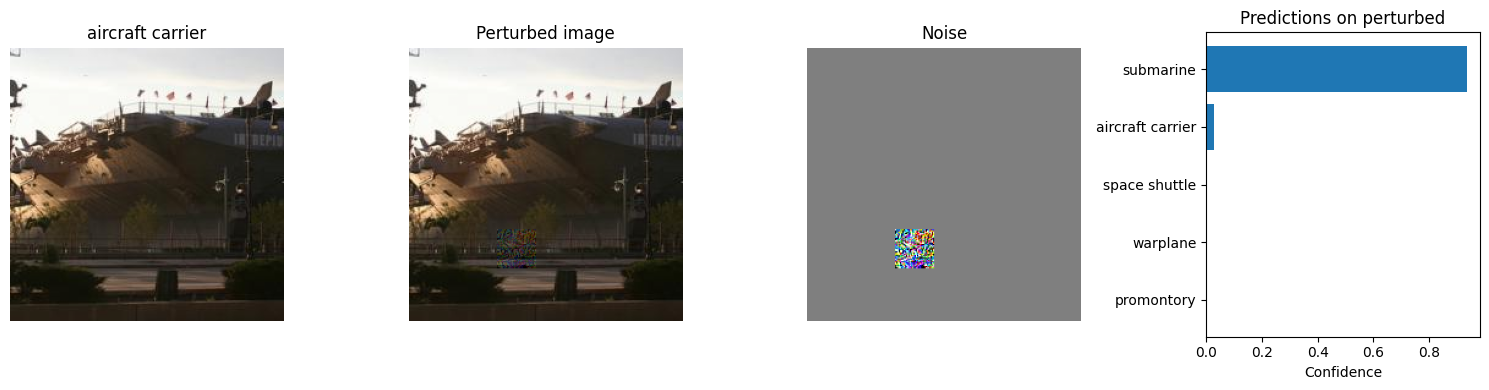

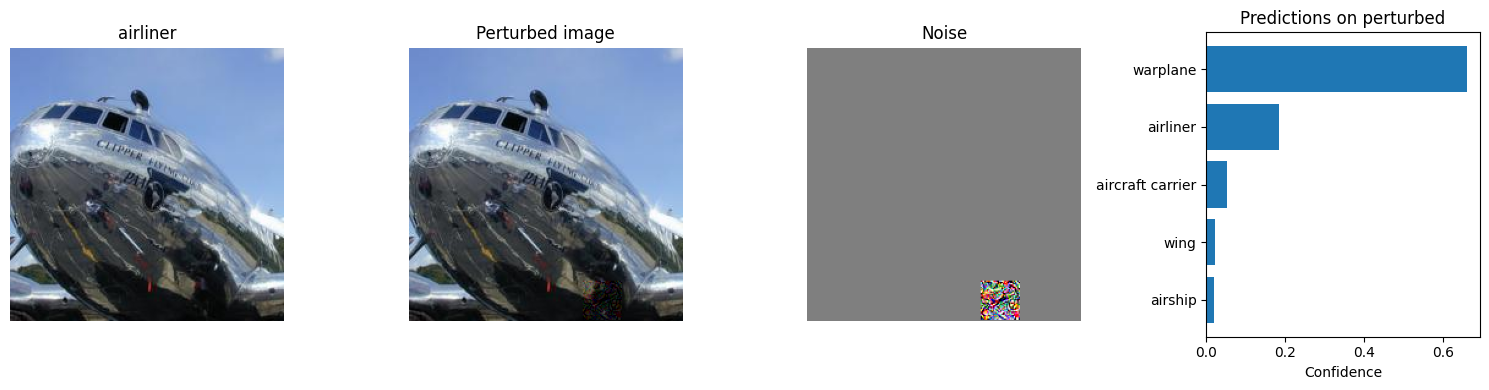

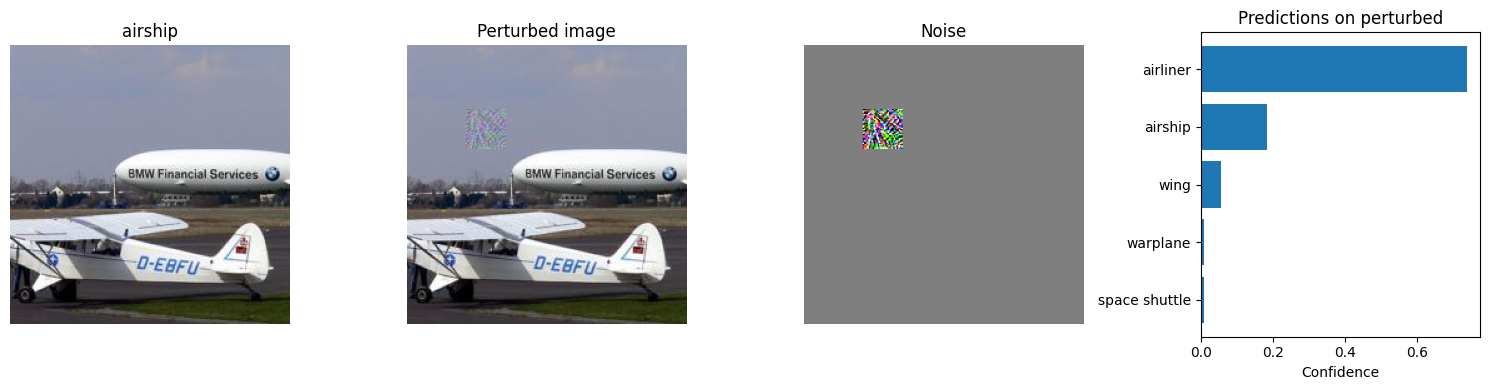

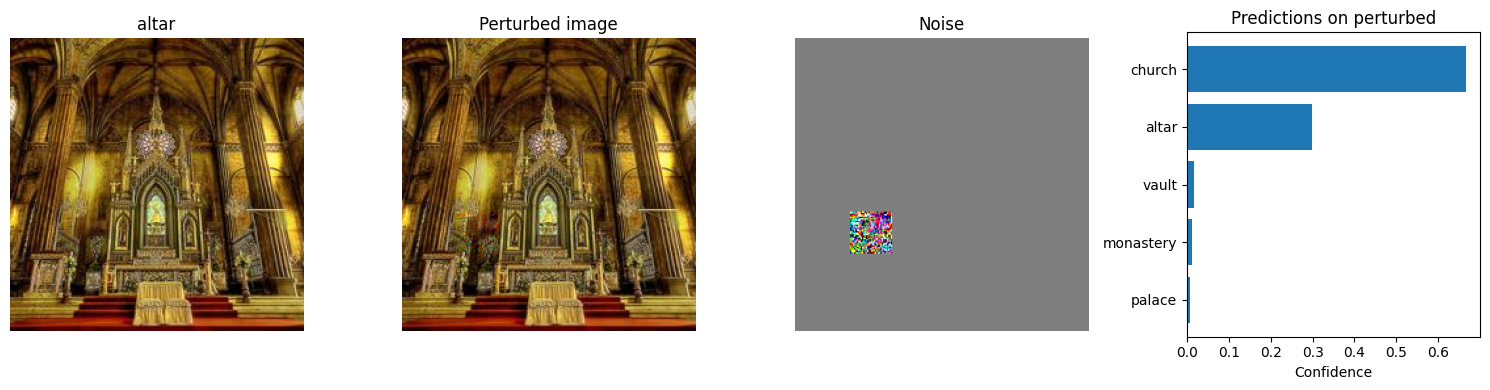

In [36]:
for i in range(5):
    example = misclassified_examples[i]

    orig_img = denormalize(example['original']).cpu()
    adv_img = denormalize(example['adversarial']).cpu()

    # you can get the noise by taking the difference between initial and
    # perturbed image
    noise = (example['adversarial'] - example['original']).cpu()
    # min-max scale the noise to be between 0 and 1, for display purposes
    noise_display = noise - noise.min()
    noise_display = noise_display / (noise_display.max() + 1e-8)

    # get the top5 predictions of the model
    # on the perturbed image
    adv_confidences = example['adv_confidences']
    top5_indices = np.argsort(adv_confidences)[-5:]
    top5_values = adv_confidences[top5_indices]
    top5_names = [class_idx_to_labels[idx] for idx in top5_indices]

    fig, axs = plt.subplots(1, 4, figsize=(15, 4))

    # plot true image
    axs[0].imshow(orig_img.permute(1, 2, 0))
    axs[0].set_title(f"{class_idx_to_labels[example['true_label']]}")
    axs[0].axis('off')

    # plot perturbed image
    axs[1].imshow(adv_img.permute(1, 2, 0))
    axs[1].set_title("Perturbed image")
    axs[1].axis('off')

    # plot noise
    axs[2].imshow(noise_display.permute(1, 2, 0))
    axs[2].set_title("Noise")
    axs[2].axis('off')

    # plot prediction on perturbed
    axs[3].barh(top5_names, top5_values)
    axs[3].set_title("Predictions on perturbed")
    axs[3].set_xlabel("Confidence")

    plt.tight_layout()
    plt.show()

# Task 5: Transferring attacks

In [37]:
new_model = torchvision.models.densenet121(weights='IMAGENET1K_V1').to(device)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 185MB/s]


In [38]:
dataset_paths = [f"/kaggle/working/Adversarial_Test_Set_{i+1}" for i in range(3)]
datasets = [dataset] + [torchvision.datasets.ImageFolder(root=dataset_paths[i], transform=plain_transforms) for i in range(3)]

In [39]:
for i, ds in enumerate(datasets):
    # using a data loader to loop through entire dataset later
    batch_size = 32
    loader = DataLoader(ds, batch_size = batch_size, shuffle = False, drop_last = False)
    cor_preds = 0
    cor_preds_top5 = 0
    total_samples = 0
    new_model.eval()
    # eval loop
    for inputs, labels in loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            outputs = new_model(inputs) # getting predictions

        top5_indices = outputs.topk(5).indices # getting top5 predictions
        # with a for loop, we'll accumulate across batch quantities for metrics computation
        for l, idx, top5_idx in zip(labels, outputs.argmax(-1), top5_indices):
            idx = idx.item()
            l = l.item()
            converted_l = idx_inv_converter[l] # need to convert classes from our test dataset to imagenet classes
            if idx == converted_l: # top1 correct prediction
                cor_preds += 1
            if converted_l in top5_idx: # top5 correct prediction
                cor_preds_top5 += 1
        total_samples += inputs.shape[0]

    print(f"-------- Result for dataset {i} --------")
    final_top1_acc = 100 * cor_preds / total_samples
    final_top5_acc = 100 * cor_preds_top5 / total_samples
    print(f"Top-1 Accuracy: {final_top1_acc:.2f}%")
    print(f"Top-5 Accuracy: {final_top5_acc:.2f}%")

-------- Result for dataset 0 --------
Top-1 Accuracy: 74.80%
Top-5 Accuracy: 93.60%
-------- Result for dataset 1 --------
Top-1 Accuracy: 65.20%
Top-5 Accuracy: 89.80%
-------- Result for dataset 2 --------
Top-1 Accuracy: 70.40%
Top-5 Accuracy: 93.00%
-------- Result for dataset 3 --------
Top-1 Accuracy: 73.20%
Top-5 Accuracy: 93.60%


## Comments

Interestingly, attacks transfer to a certain amount to a new neural network they weren't trained on. For the first 2 attacks we see a nearly 10% drop in top1 accuracy. This means that some attacks target vulnerabilities that come from a property shared between neural networks, maybe a property induced by the way they are trained. As expected, the patch attack transfered worse than the two first attacks.

To mitigate transferability, one can train neural networks to be robust to attacks, by incorporating attack images as data augmentation. This could also improve the results of the models.